# Classification Model Analysis

## Import library

In [463]:
import numpy as np
import pickle, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, cross_val_predict

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score

# from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

## Read the data
Here we introduce the 200+ Financial Indicators of US stocks (2014-2018) data as the raw dataset.

In [409]:
path = './data/200+ Financial Indicators of US stocks (2014-2018)/'
df1 = pd.read_csv(path + '2014_Financial_Data.csv')
df2 = pd.read_csv(path + '2015_Financial_Data.csv')
df3 = pd.read_csv(path + '2016_Financial_Data.csv')
df4 = pd.read_csv(path + '2017_Financial_Data.csv')
df5 = pd.read_csv(path + '2018_Financial_Data.csv')


In [410]:
# Check each file's schema
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(3808, 225)
(4120, 225)
(4797, 225)
(4960, 225)
(4392, 225)


In [411]:
# Here we verify if the columns are the same among all files.
df1_columns = df1.columns
df2_columns = df2.columns
df3_columns = df3.columns
df4_columns = df4.columns
df5_columns = df5.columns
i=1
for a,b,c,d,e in zip(df1_columns, df2_columns, df3_columns, df4_columns, df5_columns):
    if((a == b == c == d == e) == False):
        print(i)
        print (a + ' ' + b + ' ' + c + ' ' + d + ' ' + e)
    i+=1

224
2015 PRICE VAR [%] 2016 PRICE VAR [%] 2017 PRICE VAR [%] 2018 PRICE VAR [%] 2019 PRICE VAR [%]


## Check the files
Here we check the data types, investigate the missing data and prepare necessary encoding.

In [412]:
# Check data types
def checkDataTypes(df):
    i = 0
    for type in df.dtypes:
        if ((type != np.float) & (type != np.int32) & (type != np.int64)):
            print('Column: ' + df.columns[i] + ' = ' +  str(type))
        i+=1

In [413]:
checkDataTypes(df1)

Column: Unnamed: 0 = object
Column: Sector = object


In [414]:
checkDataTypes(df2)

Column: Unnamed: 0 = object
Column: Sector = object


In [415]:
checkDataTypes(df3)

Column: Unnamed: 0 = object
Column: Sector = object


In [416]:
checkDataTypes(df4)

Column: Unnamed: 0 = object
Column: Sector = object


In [417]:
checkDataTypes(df5)

Column: Unnamed: 0 = object
Column: Sector = object


In [418]:
# Rename the first column
df1.rename(columns={'Unnamed: 0': 'Stock'}, inplace=True)
df2.rename(columns={'Unnamed: 0': 'Stock'}, inplace=True)
df3.rename(columns={'Unnamed: 0': 'Stock'}, inplace=True)
df4.rename(columns={'Unnamed: 0': 'Stock'}, inplace=True)
df5.rename(columns={'Unnamed: 0': 'Stock'}, inplace=True)


In [419]:
# print(df1.columns)
df1_backup = df1.copy()
df1.drop(columns=['Sector'], inplace=True)
print(df1.shape)
df2_backup = df2.copy()
df2.drop(columns=['Sector'], inplace=True)
print(df2.shape)
df3_backup = df3.copy()
df3.drop(columns=['Sector'], inplace=True)
print(df3.shape)
df4_backup = df4.copy()
df4.drop(columns=['Sector'], inplace=True)
print(df4.shape)
df5_backup = df5.copy()
df5.drop(columns=['Sector'], inplace=True)
print(df5.shape)

(3808, 224)
(4120, 224)
(4797, 224)
(4960, 224)
(4392, 224)


In [420]:
print('2014_Financial_Data.csv shape: {}'.format(df1.shape))
print('2015_Financial_Data.csv shape: {}'.format(df2.shape))
print('2016_Financial_Data.csv shape: {}'.format(df3.shape))
print('2017_Financial_Data.csv shape: {}'.format(df4.shape))
print('2018_Financial_Data.csv shape: {}'.format(df5.shape))

2014_Financial_Data.csv shape: (3808, 224)
2015_Financial_Data.csv shape: (4120, 224)
2016_Financial_Data.csv shape: (4797, 224)
2017_Financial_Data.csv shape: (4960, 224)
2018_Financial_Data.csv shape: (4392, 224)


In [421]:
# Add Year column
df1['Data Year'] = 2014
df2['Data Year'] = 2015
df3['Data Year'] = 2016
df4['Data Year'] = 2017
df5['Data Year'] = 2018
# Rename Price VAR column
df1.rename(columns={'2015 PRICE VAR [%]':'Next Year VAR%'}, inplace=True)
df2.rename(columns={'2016 PRICE VAR [%]':'Next Year VAR%'}, inplace=True)
df3.rename(columns={'2017 PRICE VAR [%]':'Next Year VAR%'}, inplace=True)
df4.rename(columns={'2018 PRICE VAR [%]':'Next Year VAR%'}, inplace=True)
df5.rename(columns={'2019 PRICE VAR [%]':'Next Year VAR%'}, inplace=True)

In [422]:
# concate 5-year data files
stock_data = pd.concat([df1,df2,df3,df4,df5], axis=0)
print(stock_data.shape)
print('Total rows are equal? ' + str(stock_data.shape[0] == df1.shape[0]+df2.shape[0]+df3.shape[0]+df4.shape[0]+df5.shape[0]))

(22077, 225)
Total rows are equal? True


In [423]:
# Re-order data columns
columns = stock_data.columns.to_list()
new_columns = []
new_columns.append(columns[-1])
new_columns.append(columns[0])
new_columns.append(columns[-2])
new_columns.append(columns[-3])
new_columns.extend(columns[1:-3])

stock_data = stock_data[new_columns]
stock_data

,Data Year,Stock,Class,Next Year VAR%,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,...,10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth
0,2014,PG,0,-9.323276,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,...,0.1013,0.0834,0.0751,-0.0187,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746
1,2014,VIPS,0,-25.512193,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6484,1.7313
2,2014,KR,1,33.118297,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,...,0.0000,0.1215,0.1633,0.0618,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234
3,2014,RAD,1,2.752291,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,...,0.0000,0.0000,0.0000,0.0211,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060
4,2014,GIS,1,12.897715,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,...,0.1092,0.1250,0.1144,0.0257,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,2018,YRIV,0,-90.962099,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,3.755251e+06,...,NaN,NaN,0.0000,0.0000,0.0000,-0.0508,-0.1409,-0.0152,0.0000,-0.2602
4388,2018,YTEN,0,-77.922077,5.560000e+05,-0.4110,0.000000e+00,5.560000e+05,4.759000e+06,5.071000e+06,...,0.0000,0.0000,0.0000,0.3445,0.0000,-0.2323,-0.8602,0.0000,0.0352,-0.0993
4389,2018,ZKIN,0,-17.834400,5.488438e+07,0.2210,3.659379e+07,1.829059e+07,1.652633e+06,7.020320e+06,...,NaN,NaN,0.0000,0.1605,0.7706,0.2489,0.4074,-0.0968,0.2415,0.8987
4390,2018,ZOM,0,-73.520000,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,1.031715e+07,4.521349e+06,...,NaN,NaN,NaN,0.8980,0.0000,0.1568,-0.2200,0.0000,2.7499,0.1457


## Data Exploratory
Here we start to analyze the dataset, extract the business data and deal with missing values as well as outliers.

In [424]:
# The dataset contains stock data from 2014 to 2018.
# Total 22077 records, 225 columns.
stock_data.shape
stock_data = stock_data.replace(r'\\n',' ', regex=True)
stock_data.shape

(22077, 225)

In [425]:
s = stock_data.corr()['Class'].sort_values(ascending=False)
s.describe()
# s.plot(kind='bar', figsize=(100,10))

count    223.000000
mean       0.013328
std        0.071942
min       -0.045276
25%       -0.005953
50%        0.003965
75%        0.019107
max        1.000000
Name: Class, dtype: float64

<AxesSubplot:>

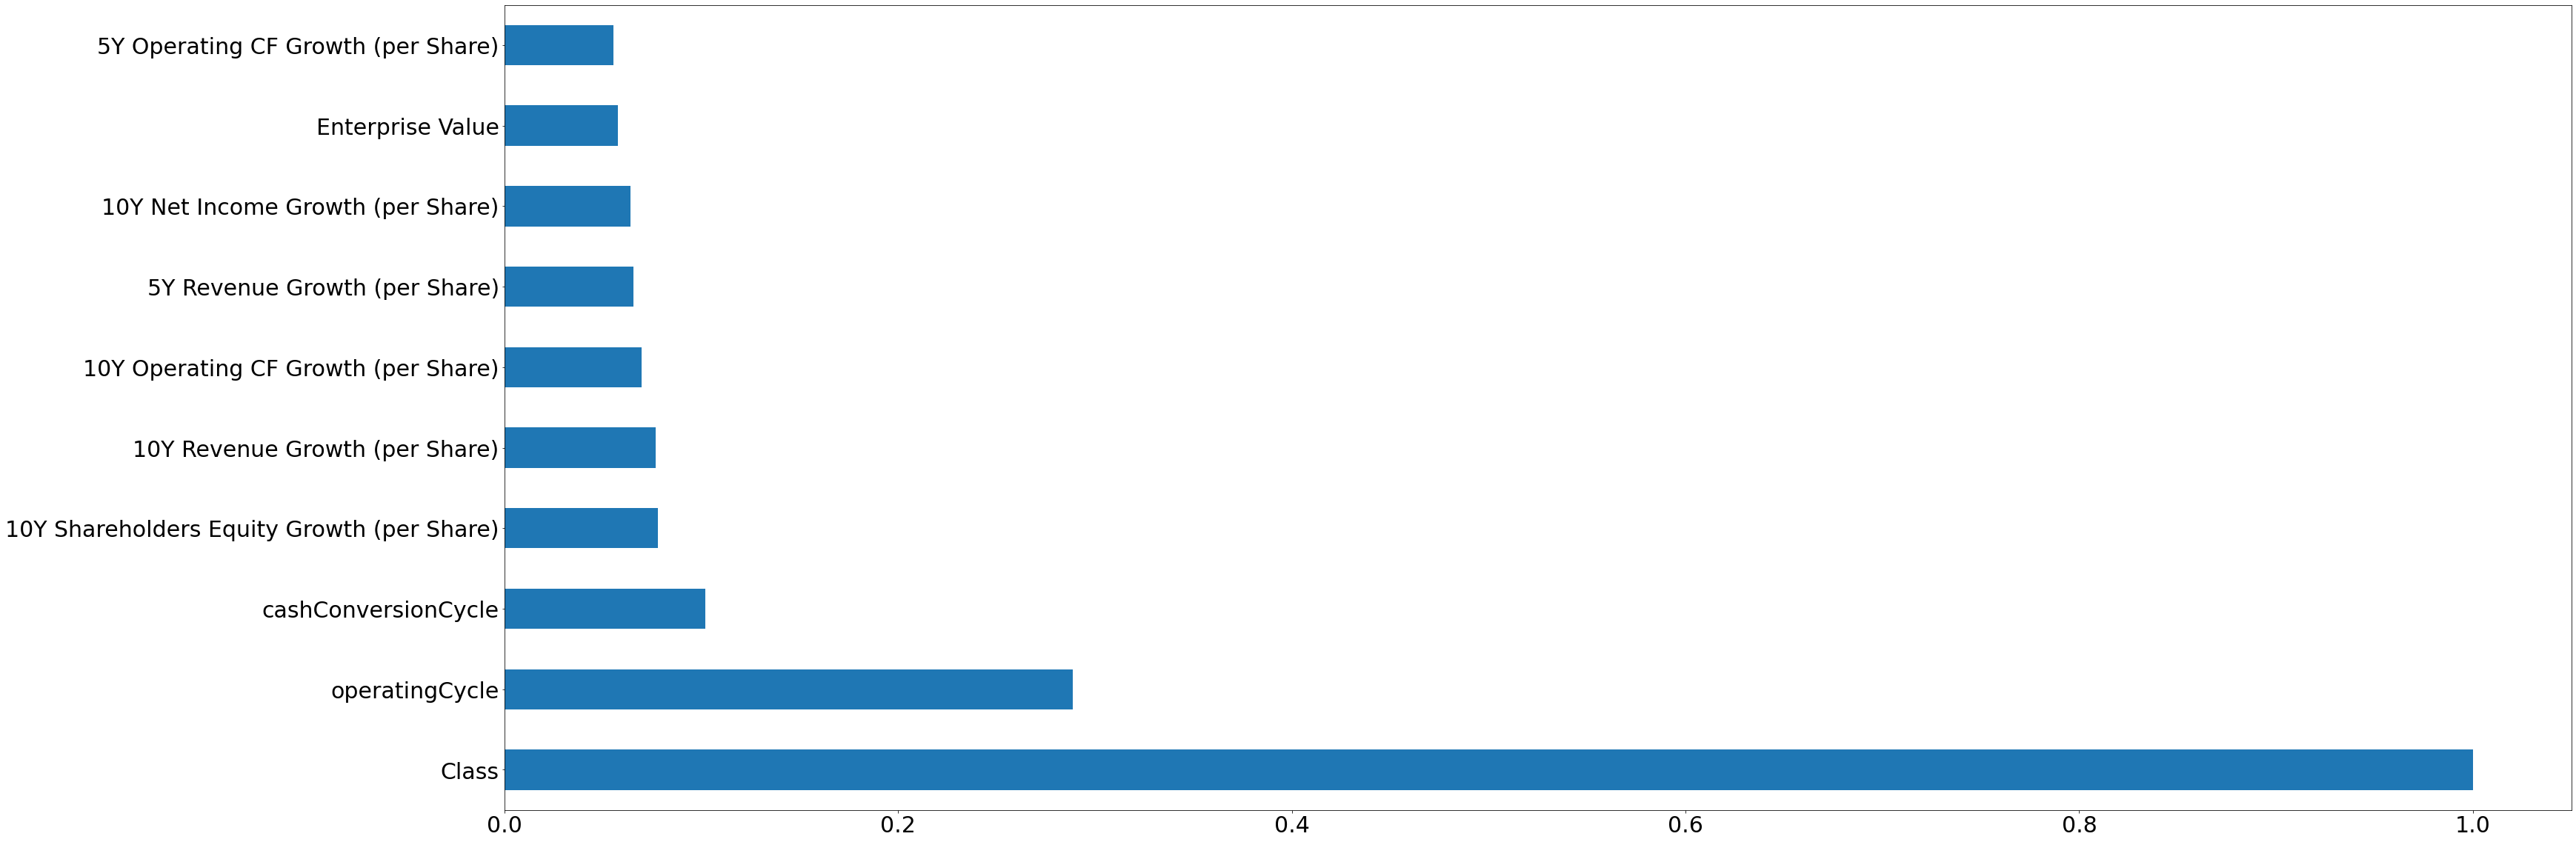

In [531]:
corr_df = stock_data.corr()
c = corr_df['Class'].sort_values(ascending=False).head(10)
# .head(20).index.values
c.plot(kind='barh', figsize=(50,20), fontsize=30)

### Analyze and extract financial indicator
From here we need to extract the most representative financial indicators as the independent variables.
The nominated indicators are:
  1. Profit Margin
  2. Net Profit Margin
  3. Operating Profit Margin
  4. EPS
  5. Return on Assets (ROA)
  6. Return on Equity (ROE)
  7. Price to Free Cash Flows Ratio
  8. Price Earnings Ratio
  9. Price Earnings to Growth Ratio
  10. Asset Turnover
  11. Current Ratio
  12. Quick Ratio
  13. Debt Equity Ratio
  14. Interest Coverage
  15. Receivables Turnover
  16. Invertory Turnover
  17. Working Capital

In [427]:
# Extract the key financial indicators from the dataset.
# The Operating Profit Margin column value is always 1, which seems incorrect.
# Therefore for this indicator using Operating Income divided by Revenue.

indicator_list = ['Data Year', 'Stock', 'Class', 'Next Year VAR%', 
                  'Profit Margin', 
                  'Net Profit Margin', 'EPS Diluted',
                 'returnOnAssets', 'returnOnEquity', 'priceToFreeCashFlowsRatio', 'priceEarningsRatio',
                 'priceEarningsToGrowthRatio', 'assetTurnover', 'currentRatio',
                 'quickRatio', 'debtEquityRatio', 'Interest Coverage', 'Receivables Turnover',
                 'Inventory Turnover', 'Working Capital']

# The following is based on correlation results
# indicator_list = ['Data Year', 'Stock', 'Class', 'Next Year VAR%', 
#                   'operatingCycle', 'cashConversionCycle',
#                   '10Y Shareholders Equity Growth (per Share)',
#                   '10Y Revenue Growth (per Share)',
#                   '10Y Operating CF Growth (per Share)',
#                   '5Y Revenue Growth (per Share)',
#                   '10Y Net Income Growth (per Share)', 'Enterprise Value',
#                   '5Y Operating CF Growth (per Share)',
#                   '5Y Dividend per Share Growth (per Share)',
#                   '5Y Net Income Growth (per Share)',
#                   '3Y Dividend per Share Growth (per Share)',
#                   '10Y Dividend per Share Growth (per Share)', 'Dividend payments',
#                   'Gross Margin', 'Earnings before Tax', 'Free Cash Flow',
#                   'Stock-based compensation', 'Operating Income']

# indicator_list = corr_df['Class'].abs().sort_values(ascending=False).head(11).index.tolist()[1:]
# print(indicator_list)
# Assign to new dataset
indicator_data = stock_data[indicator_list]
indicator_data

,Data Year,Stock,Class,Next Year VAR%,Profit Margin,Net Profit Margin,EPS Diluted,returnOnAssets,returnOnEquity,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,assetTurnover,currentRatio,quickRatio,debtEquityRatio,Interest Coverage,Receivables Turnover,Inventory Turnover,Working Capital
0,2014,PG,0,-9.323276,0.1560,0.1565,4.010,0.5765,0.1664,21.0348,18.7566,15.557842,0.515721,0.9370,0.506197,0.5061,21.4429,11.5404,10.8869,-2.109000e+09
1,2014,VIPS,0,-25.512193,0.0058,0.0364,0.226,0.0403,0.3294,1.3589,81.5526,2.631793,1.364477,0.2102,0.849993,1.5093,15.4363,NaN,NaN,3.065163e+09
2,2014,KR,1,33.118297,0.0150,0.0154,1.450,0.1011,0.2821,14.6302,12.0340,0.000000,3.359687,0.8250,0.141709,2.1007,6.1242,90.7937,18.2227,-1.875000e+09
3,2014,RAD,1,2.752291,0.0080,0.0098,4.600,0.0668,-0.1180,17.2736,28.6087,0.000000,3.675578,1.7090,0.436885,-2.7237,1.5893,27.1769,8.3030,1.777673e+09
4,2014,GIS,1,12.897715,0.1020,0.1019,2.830,0.6265,0.2792,17.6902,18.7034,15.254287,0.773777,0.8100,0.433465,1.3445,9.9540,12.2250,11.5363,-1.030000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,2018,YRIV,0,-90.962099,-1.2310,0.0000,-0.080,NaN,-0.0800,0.0000,0.0000,NaN,0.000000,NaN,0.002142,0.6850,-0.3406,0.0000,0.0000,NaN
4388,2018,YTEN,0,-77.922077,-16.4930,-16.4928,-0.920,-0.8423,-1.6093,0.0000,0.0000,NaN,0.042901,3.8860,3.815356,1.1346,0.0000,3.9857,0.0000,4.736000e+06
4389,2018,ZKIN,0,-17.834400,0.1280,0.1279,0.520,0.2228,0.1895,0.0000,6.1538,6.205677,0.718395,1.6440,1.189722,0.5202,7.7919,1.5678,3.9427,2.521620e+07
4390,2018,ZOM,0,-73.520000,NaN,0.0000,-0.180,-7.5619,-4.5523,0.0000,0.0000,NaN,0.000000,1.6250,0.839010,0.0000,0.0000,0.0000,0.0000,1.484439e+06


In [428]:
indicator_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 0 to 4391
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Data Year                   22077 non-null  int64  
 1   Stock                       22077 non-null  object 
 2   Class                       22077 non-null  int64  
 3   Next Year VAR%              22077 non-null  float64
 4   Profit Margin               19633 non-null  float64
 5   Net Profit Margin           20355 non-null  float64
 6   EPS Diluted                 20785 non-null  float64
 7   returnOnAssets              15542 non-null  float64
 8   returnOnEquity              19739 non-null  float64
 9   priceToFreeCashFlowsRatio   19800 non-null  float64
 10  priceEarningsRatio          19801 non-null  float64
 11  priceEarningsToGrowthRatio  12998 non-null  float64
 12  assetTurnover               19933 non-null  float64
 13  currentRatio                1901

### Clean NA values
Here the na values are dropped, instead of filled with zero or make-up figure to maintain feature quality.

In [429]:
def get_na_columns(df):
    columns = df.columns
    columns_has_na = []
    for column in columns:
        has_na = df[column].isna().any().sum()
        if(has_na>0):
            columns_has_na.append(column)
    return columns_has_na

In [430]:
# Deal with NA data
# Focus on financial indicator dataset.
# To maintain model quality, I drop the records with NA values instead of filling 0.
indicator_data = indicator_data.dropna()
indicator_data.shape

(9171, 20)

In [431]:
# Verify if there is any na exists.
s = get_na_columns(indicator_data)
len(s)

0

### Scale the data to improve the outliers
Here we scale the features to decrease the effects of outliers.

In [432]:
def get_box(df, columns):
    j=0
    d=0
    while (j<=4):
        figure, axs = plt.subplots(1, 4)
        figure.set_figheight(10)
        figure.set_figwidth(18)
    
        for i, column in enumerate(columns[d:d+4]):
            axs[i].boxplot(df[column], 0, 'gD', showmeans=True, 
                           widths=0.5)
            axs[i].set_title(column)
        
        j+=1
        d+=4   

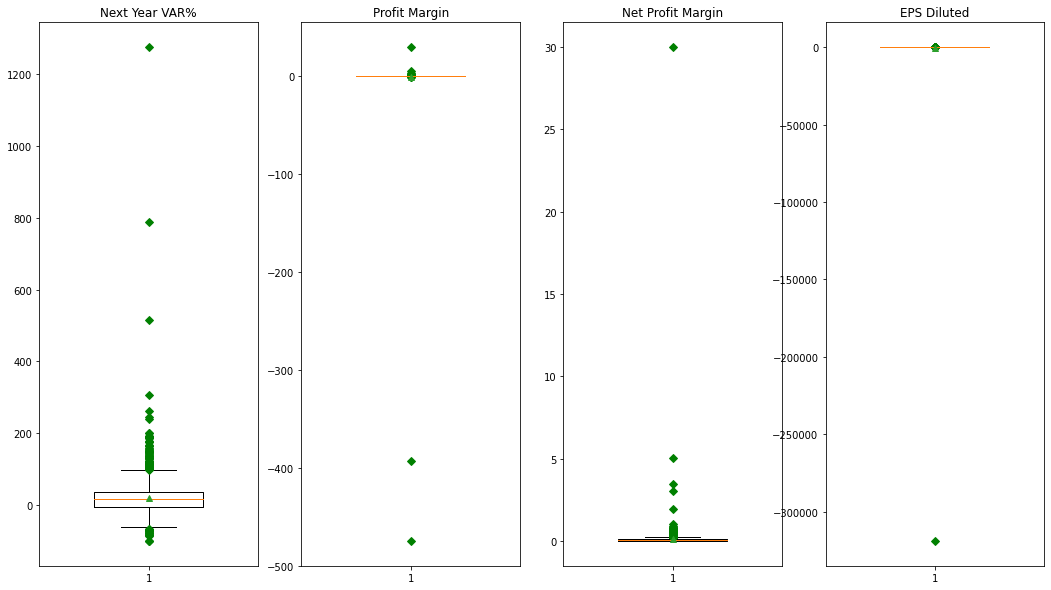

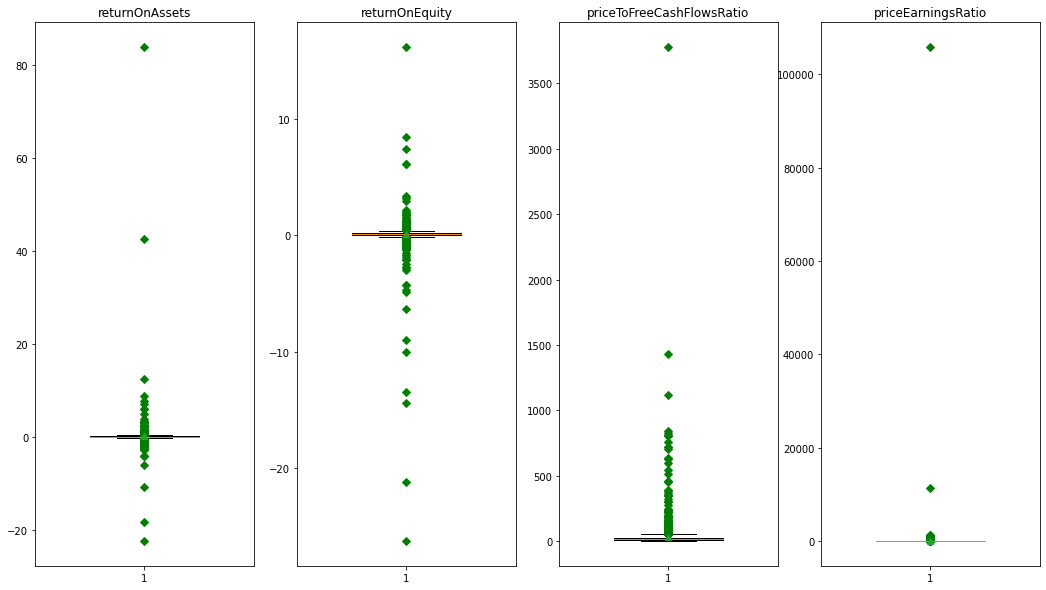

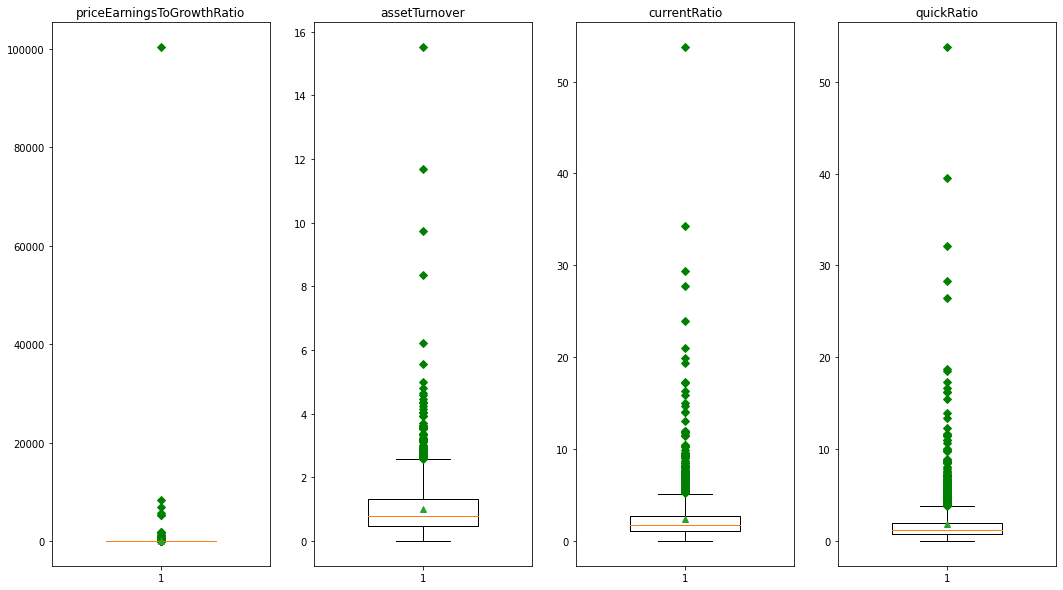

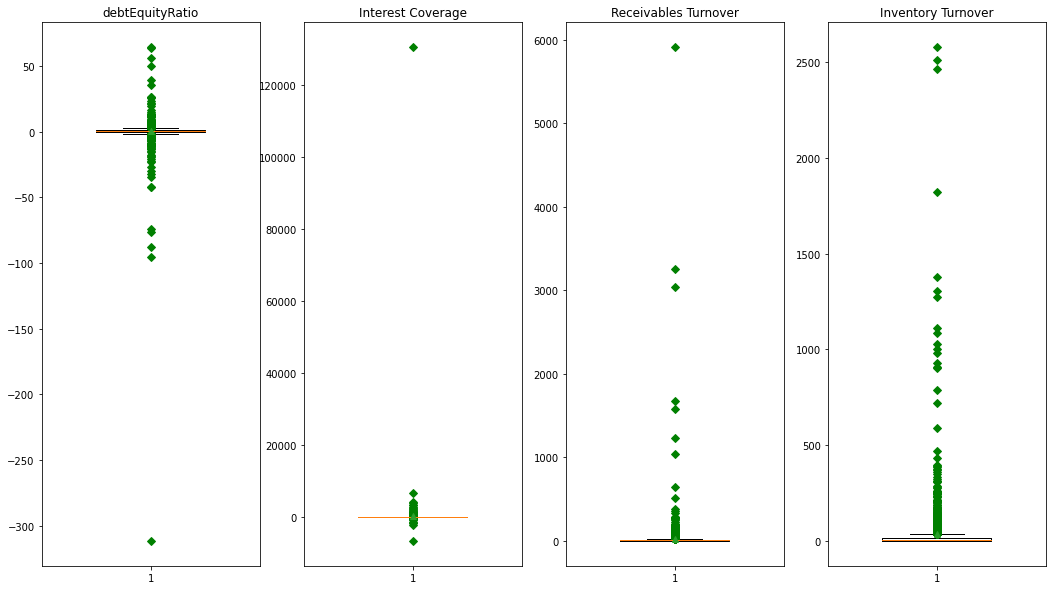

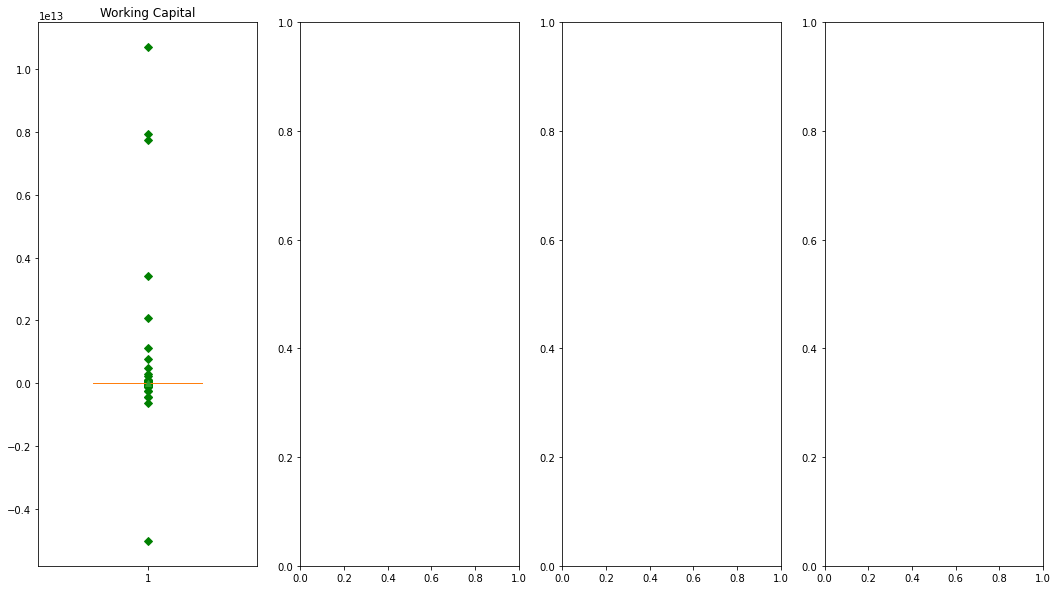

In [433]:
feature_column = indicator_data.columns.values.tolist()[3:]
get_box(indicator_data.loc[indicator_data['Data Year']==2016], feature_column)
# indicator_data.info()

In [434]:
indicator_data.reset_index(inplace=True, drop=True)

In [435]:
indicator_data

,Data Year,Stock,Class,Next Year VAR%,Profit Margin,Net Profit Margin,EPS Diluted,returnOnAssets,returnOnEquity,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,assetTurnover,currentRatio,quickRatio,debtEquityRatio,Interest Coverage,Receivables Turnover,Inventory Turnover,Working Capital
0,2014,PG,0,-9.323276,0.156,0.1565,4.01,0.5765,0.1664,21.0348,18.7566,15.557842,0.515721,0.937,0.506197,0.5061,21.4429,11.5404,10.8869,-2.109000e+09
1,2014,KR,1,33.118297,0.015,0.0154,1.45,0.1011,0.2821,14.6302,12.0340,0.000000,3.359687,0.825,0.141709,2.1007,6.1242,90.7937,18.2227,-1.875000e+09
2,2014,RAD,1,2.752291,0.008,0.0098,4.60,0.0668,-0.1180,17.2736,28.6087,0.000000,3.675578,1.709,0.436885,-2.7237,1.5893,27.1769,8.3030,1.777673e+09
3,2014,GIS,1,12.897715,0.102,0.1019,2.83,0.6265,0.2792,17.6902,18.7034,15.254287,0.773777,0.810,0.433465,1.3445,9.9540,12.2250,11.5363,-1.030000e+09
4,2014,PM,1,13.980937,0.094,0.0935,4.76,1.1630,-0.5933,19.2150,17.1113,13.892366,2.276579,1.025,0.376257,-2.3323,11.0665,20.3910,8.6892,3.720000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9166,2018,WSTG,1,68.702657,0.019,0.0195,0.78,0.0936,0.0872,3.1962,12.8205,11.974646,1.680488,1.543,1.491156,0.0000,-4.6417,2.1331,85.0452,3.621400e+07
9167,2018,WTT,0,-17.816095,0.001,0.0007,0.00,0.0026,0.0011,11.7688,0.0000,1054.818857,1.195191,1.940,1.191985,0.0630,1.1443,5.9718,7.8729,1.077200e+07
9168,2018,WVVI,0,-3.076927,0.080,0.1239,0.37,0.0510,0.0601,0.0000,18.6216,11.965943,0.375387,5.307,2.240921,0.1756,9.6076,11.2230,1.4871,2.323907e+07
9169,2018,XELB,1,27.118650,0.031,0.0307,0.06,0.0993,0.0109,4.0370,18.8333,18.986480,0.256890,1.481,1.231509,0.1960,3.8872,3.6305,35.6801,7.759000e+06


In [436]:
def check_IQR(df, column):
    scale = 1.5
    describe_df = df[column].describe()
    Q1 = describe_df['25%']
    Q3 = describe_df['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - scale*IQR
    upper_bound = Q3 + scale*IQR
    return df[column].loc[(df[column]<lower_bound)|(df[column]>upper_bound)]

In [438]:
a = check_IQR(indicator_data, 'EPS Diluted')
a.sort_values(ascending=False)
indicator_data.iloc[4339]

Data Year                           2016
Stock                               TOPS
Class                                  0
Next Year VAR%                  -99.9994
Profit Margin                     -0.012
Net Profit Margin                  0.037
EPS Diluted                      -319100
returnOnAssets                    0.0094
returnOnEquity                    0.0231
priceToFreeCashFlowsRatio              0
priceEarningsRatio                     0
priceEarningsToGrowthRatio       0.40038
assetTurnover                   0.198392
currentRatio                       0.227
quickRatio                     0.0717316
debtEquityRatio                   1.8571
Interest Coverage                 1.3401
Receivables Turnover             355.413
Inventory Turnover                57.732
Working Capital              -1.5492e+07
Name: 4339, dtype: object

In [439]:
# Use 1.5 IQR to isolate and drop outliers
check_columns = indicator_list[3:]
check_columns
tmp_index_list=[]
for check_column in check_columns:
    column_outlier_df = check_IQR(indicator_data, check_column)
    print('Column {} has {} outlier data'.format(check_column, column_outlier_df.shape[0]))
#     add index to temp list
    tmp_index_list.extend(column_outlier_df.index.values.tolist())

outlier_index = set(tmp_index_list)
# Try to drop the outliers
indicator_data.drop(index=outlier_index, inplace=True)
indicator_data.shape
indicator_data['Data Year'].value_counts()

Column Next Year VAR% has 249 outlier data
Column Profit Margin has 618 outlier data
Column Net Profit Margin has 621 outlier data
Column EPS Diluted has 583 outlier data
Column returnOnAssets has 937 outlier data
Column returnOnEquity has 963 outlier data
Column priceToFreeCashFlowsRatio has 738 outlier data
Column priceEarningsRatio has 957 outlier data
Column priceEarningsToGrowthRatio has 967 outlier data
Column assetTurnover has 386 outlier data
Column currentRatio has 683 outlier data
Column quickRatio has 769 outlier data
Column debtEquityRatio has 1041 outlier data
Column Interest Coverage has 1329 outlier data
Column Receivables Turnover has 1242 outlier data
Column Inventory Turnover has 1397 outlier data
Column Working Capital has 1614 outlier data


C:\Users\mikee\Anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


2018    524
2017    509
2016    462
2014    460
2015    424
Name: Data Year, dtype: int64

In [380]:
indicator_data.loc[indicator_data['Data Year']==2018]

,Data Year,Stock,Class,Next Year VAR%,Profit Margin,Net Profit Margin,EPS Diluted,returnOnAssets,returnOnEquity,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,assetTurnover,currentRatio,quickRatio,debtEquityRatio,Interest Coverage,Receivables Turnover,Inventory Turnover,Working Capital
7235,2018,GSM,0,-43.373493,0.019,0.0192,0.25,0.0343,0.0568,0.0000,6.3600,6.242092,1.070732,1.768,0.784809,0.7291,2.0947,15.6321,5.5586,3.835020e+08
7256,2018,SWN,0,-34.946235,0.139,0.1390,0.93,0.1127,0.2273,1.2433,3.6667,3.648965,0.666207,1.130,1.078014,0.9814,3.2510,7.6551,0.0000,1.100000e+08
7266,2018,XRX,1,88.736279,0.037,0.0367,1.38,0.1514,0.0721,4.4843,14.1143,12.940137,0.660885,1.444,1.793910,1.0450,0.0000,1.9945,11.3445,1.444000e+09
7267,2018,X,0,-37.531885,0.079,0.0786,6.25,0.1716,0.2653,0.0000,2.8906,2.884312,1.291022,1.511,0.992180,0.5666,3.6026,7.0345,7.4037,1.633000e+09
7306,2018,KNX,1,39.723202,0.078,0.0785,2.36,0.1443,0.0768,12.6146,10.5781,10.543334,0.675448,1.476,1.217149,0.1701,19.2517,9.0925,0.0000,2.926690e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9148,2018,SXI,1,16.453900,0.048,0.0475,2.86,0.1018,0.0812,31.2470,35.9375,35.928845,0.840245,2.380,1.421740,0.4298,10.4044,6.2424,6.8882,2.226180e+08
9154,2018,TRNS,1,63.636373,0.038,0.0382,0.81,0.1625,0.1153,27.4958,18.6145,18.585917,1.602332,1.916,1.258723,0.4450,8.3729,6.2911,13.5323,1.936300e+07
9163,2018,WHLM,0,-28.987994,0.011,0.0110,0.16,0.1239,0.0328,9.3759,36.4375,36.287664,1.800481,1.299,1.285872,0.1005,12.7723,6.0993,0.0000,4.343000e+06
9169,2018,XELB,1,27.118650,0.031,0.0307,0.06,0.0993,0.0109,4.0370,18.8333,18.986480,0.256890,1.481,1.231509,0.1960,3.8872,3.6305,35.6801,7.759000e+06


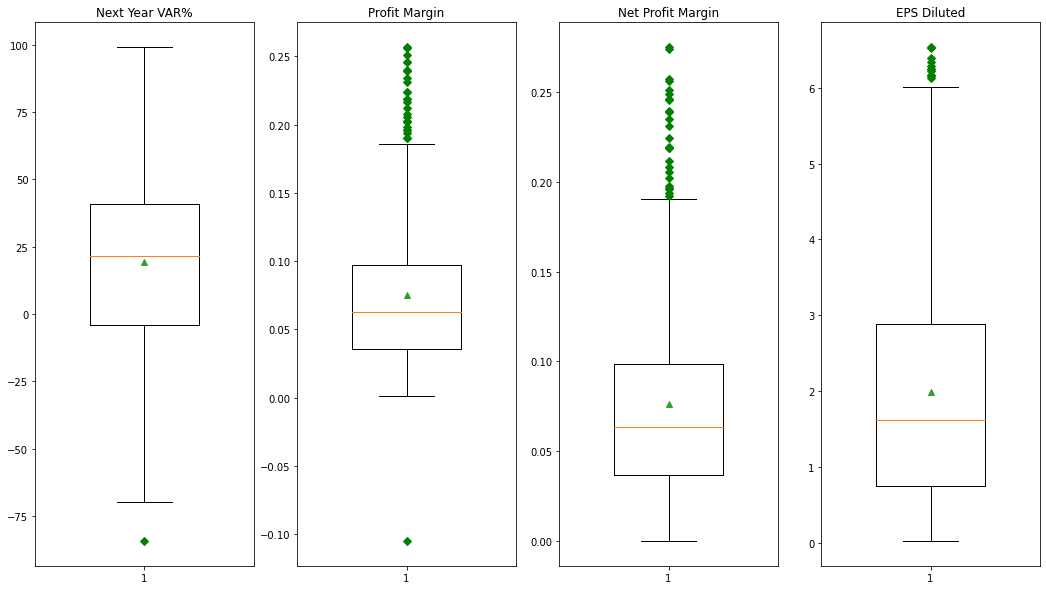

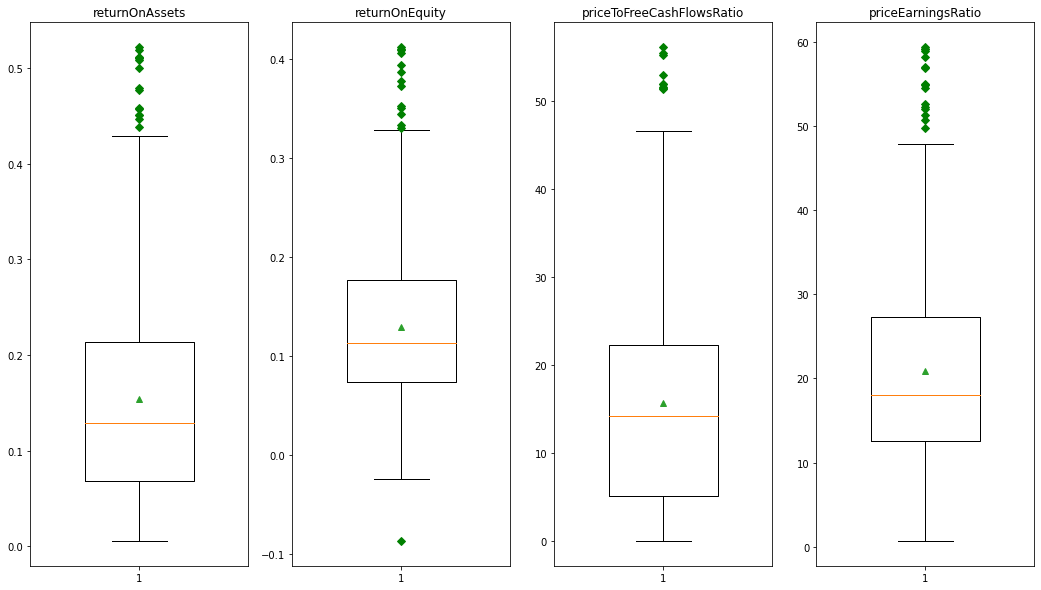

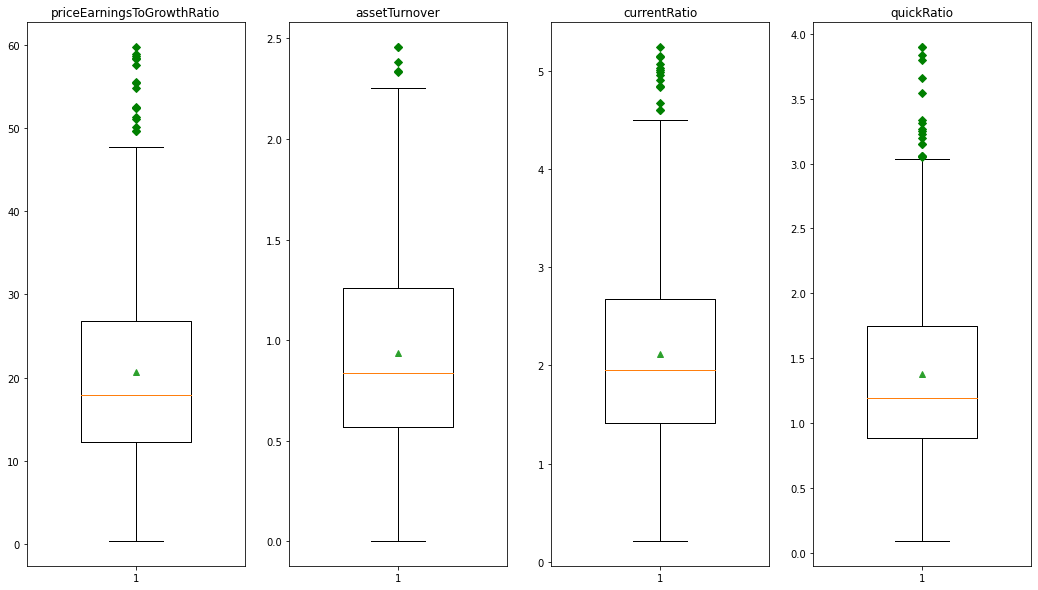

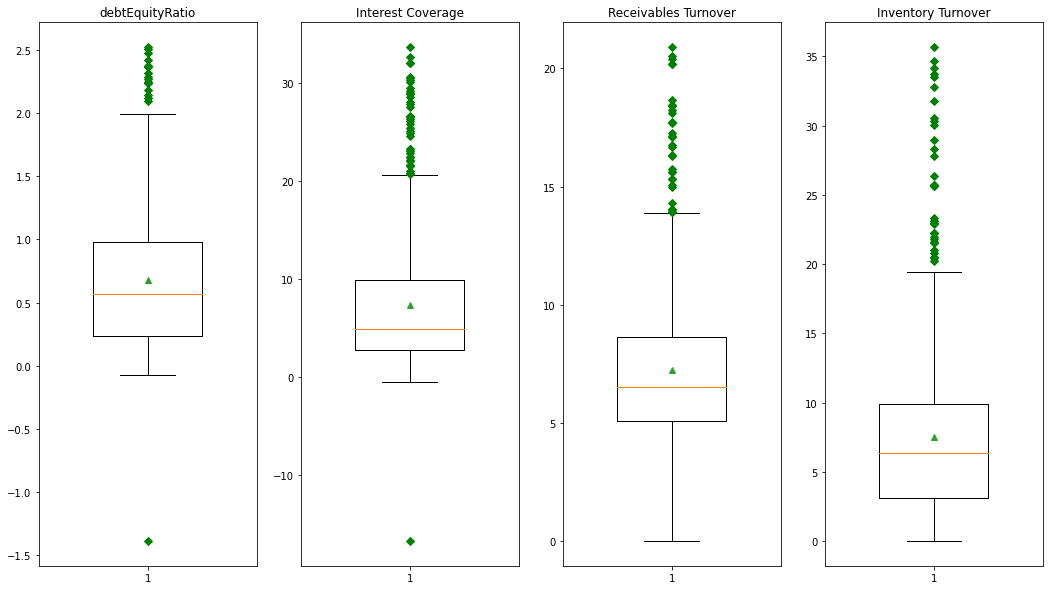

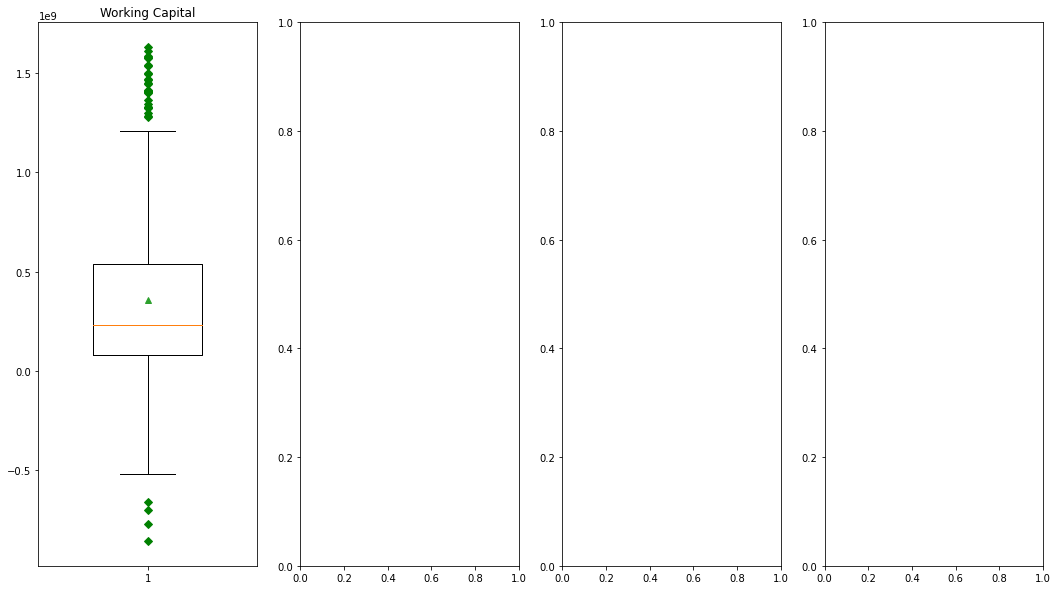

In [381]:
feature_column = indicator_data.columns.values.tolist()[3:]
# get_box(indicator_data.loc[indicator_data['Data Year']==2018], feature_column)
indicator_data.loc[indicator_data['Data Year']==2018]
get_box(indicator_data.loc[indicator_data['Data Year']==2018], feature_column)

In [382]:
columns = indicator_data.columns.values.tolist()[3:]

In [383]:
# Before scaling
# example[columns].describe().T
indicator_data[feature_column].describe().T

,count,mean,std,min,25%,50%,75%,max
Next Year VAR%,2379.0,7.074106e+00,3.337413e+01,-8.556701e+01,-1.504449e+01,6.276004e+00,3.070100e+01,9.911827e+01
Profit Margin,2379.0,7.285334e-02,4.910495e-02,-1.050000e-01,3.700000e-02,6.200000e-02,9.565000e-02,2.640000e-01
Net Profit Margin,2379.0,7.434548e-02,4.957622e-02,0.000000e+00,3.760000e-02,6.330000e-02,9.665000e-02,2.751000e-01
EPS Diluted,2379.0,1.849880e+00,1.447367e+00,-1.200000e+00,7.200000e-01,1.500000e+00,2.575000e+00,6.550000e+00
returnOnAssets,2379.0,1.479193e-01,1.092126e-01,-2.031000e-01,6.480000e-02,1.184000e-01,2.043000e-01,5.221000e-01
returnOnEquity,2379.0,1.257464e-01,7.602930e-02,-8.750000e-02,7.140000e-02,1.080000e-01,1.621000e-01,4.127000e-01
priceToFreeCashFlowsRatio,2379.0,1.661447e+01,1.291435e+01,0.000000e+00,7.022350e+00,1.565270e+01,2.364485e+01,5.634670e+01
priceEarningsRatio,2379.0,2.354212e+01,1.210078e+01,0.000000e+00,1.517025e+01,2.106670e+01,2.965625e+01,6.039740e+01
priceEarningsToGrowthRatio,2379.0,2.203469e+01,1.237565e+01,0.000000e+00,1.421282e+01,1.962366e+01,2.852856e+01,6.002240e+01
assetTurnover,2379.0,9.330105e-01,5.046295e-01,0.000000e+00,5.507223e-01,8.329847e-01,1.241908e+00,2.526786e+00


In [384]:
# Scale the rest features
scaler = MinMaxScaler()
# scaler = RobustScaler()
example_standardized = scaler.fit_transform(indicator_data[feature_column])
# example_standardized.shape
example_standardized_df = pd.DataFrame(data=example_standardized, columns=feature_column)

In [441]:
example_standardized_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Next Year VAR%,2379.0,0.501616,0.180708,0.0,0.381852,0.497295,0.629547,1.0
Profit Margin,2379.0,0.481987,0.133076,0.0,0.384824,0.452575,0.543767,1.0
Net Profit Margin,2379.0,0.270249,0.180212,0.0,0.136678,0.230098,0.351327,1.0
EPS Diluted,2379.0,0.393533,0.186757,0.0,0.247742,0.348387,0.487097,1.0
returnOnAssets,2379.0,0.484031,0.150597,0.0,0.369415,0.443326,0.561776,1.0
returnOnEquity,2379.0,0.426322,0.151998,0.0,0.317673,0.390844,0.499000,1.0
priceToFreeCashFlowsRatio,2379.0,0.294861,0.229194,0.0,0.124628,0.277793,0.419631,1.0
priceEarningsRatio,2379.0,0.389787,0.200353,0.0,0.251174,0.348801,0.491019,1.0
priceEarningsToGrowthRatio,2379.0,0.367108,0.206184,0.0,0.236792,0.326939,0.475298,1.0
assetTurnover,2379.0,0.369248,0.199712,0.0,0.217954,0.329662,0.491497,1.0


In [442]:
indicator_data.shape
a = indicator_data[['Data Year', 'Stock', 'Class']]
# a.dropna(inplace=True)
a.reset_index(inplace=True, drop=True)
a
example_standardized_df
indicator_data = pd.concat([a, example_standardized_df], axis=1)
indicator_data

,Data Year,Stock,Class,Next Year VAR%,Profit Margin,Net Profit Margin,EPS Diluted,returnOnAssets,returnOnEquity,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,assetTurnover,currentRatio,quickRatio,debtEquityRatio,Interest Coverage,Receivables Turnover,Inventory Turnover,Working Capital
0,2014,KO,1,0.492223,0.701897,0.560887,0.361290,0.922090,0.642943,0.389840,0.431504,0.377749,0.197822,0.191423,0.198050,0.706536,0.728639,0.471113,0.392013,0.594519
1,2014,NWL,1,0.564045,0.463415,0.239913,0.329032,0.821153,0.582967,0.395260,0.460333,0.409730,0.345279,0.228557,0.187612,0.697294,0.501554,0.232776,0.223452,0.511755
2,2014,CAG,1,0.580404,0.355014,0.093057,0.245161,0.360039,0.290084,0.159976,0.564784,0.516089,0.242505,0.302255,0.108014,0.789380,0.374341,0.484356,0.145629,0.982288
3,2014,SJM,1,0.602101,0.558266,0.366049,0.854194,0.686156,0.399640,0.302980,0.295337,0.000000,0.245077,0.328344,0.125478,0.467552,0.560114,0.861273,0.162496,0.610921
4,2014,DG,1,0.478266,0.444444,0.213013,0.563871,0.686983,0.554378,0.335102,0.294162,0.000000,0.637444,0.334247,0.063433,0.488256,0.709847,0.000000,0.192178,0.904939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,2018,SXI,1,0.552404,0.414634,0.172664,0.523871,0.420436,0.337265,0.554549,0.595017,0.598591,0.332535,0.450602,0.354528,0.464769,0.534551,0.298545,0.187178,0.439880
2375,2018,TRNS,1,0.807879,0.387534,0.138859,0.259355,0.504137,0.405438,0.487975,0.308200,0.309650,0.634138,0.362241,0.313001,0.468649,0.494514,0.300874,0.367723,0.359159
2376,2018,WHLM,0,0.306354,0.314363,0.039985,0.175484,0.450910,0.240504,0.166397,0.603296,0.604569,0.712558,0.244744,0.319917,0.380700,0.581218,0.291701,0.000000,0.353194
2377,2018,XELB,1,0.610150,0.368564,0.111596,0.162581,0.416988,0.196721,0.071646,0.311823,0.316323,0.101667,0.279403,0.306069,0.405080,0.406110,0.173630,0.969560,0.354551


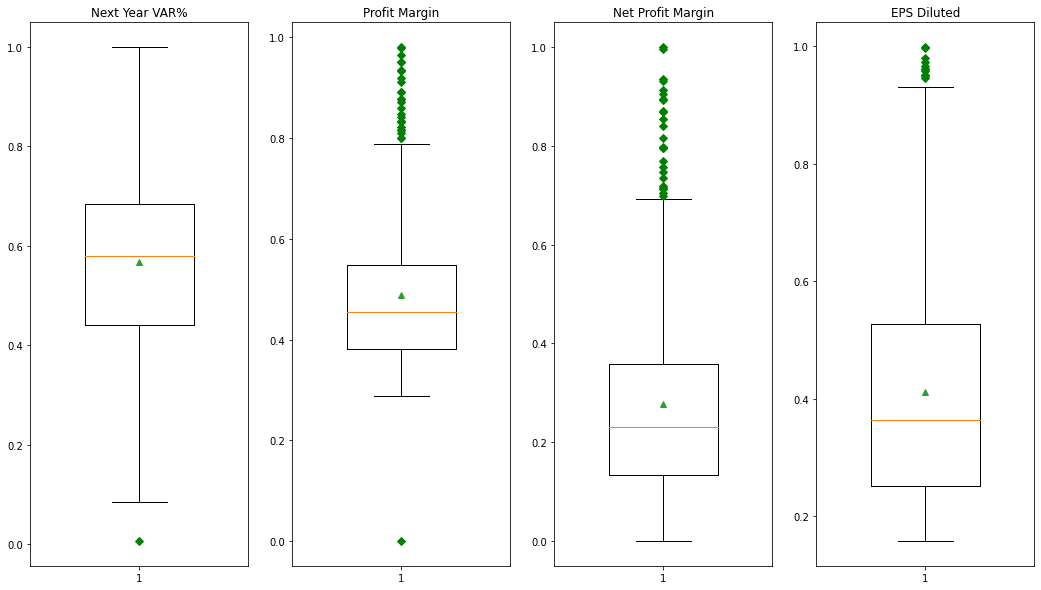

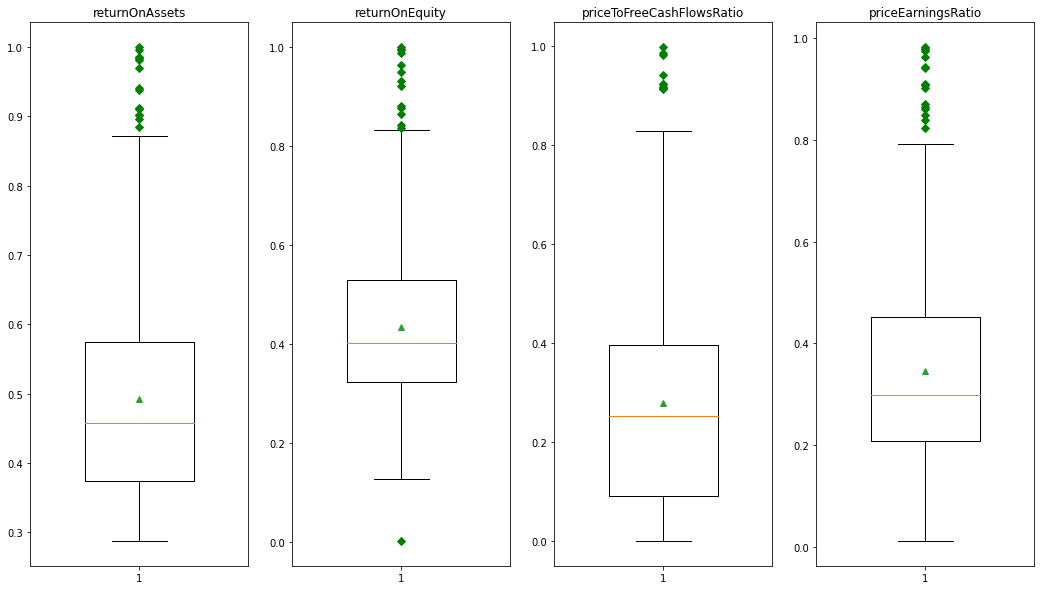

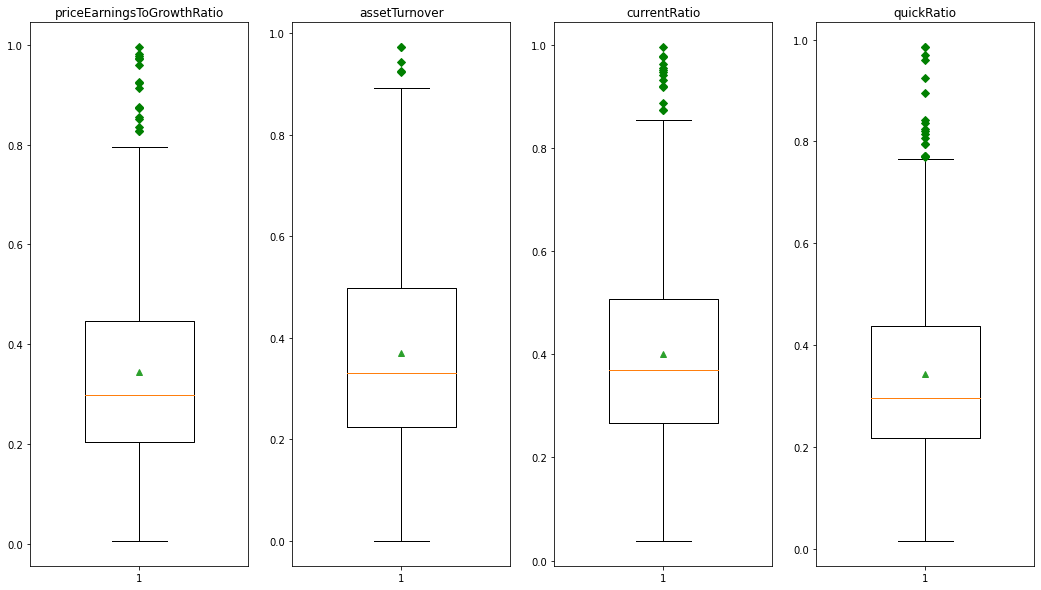

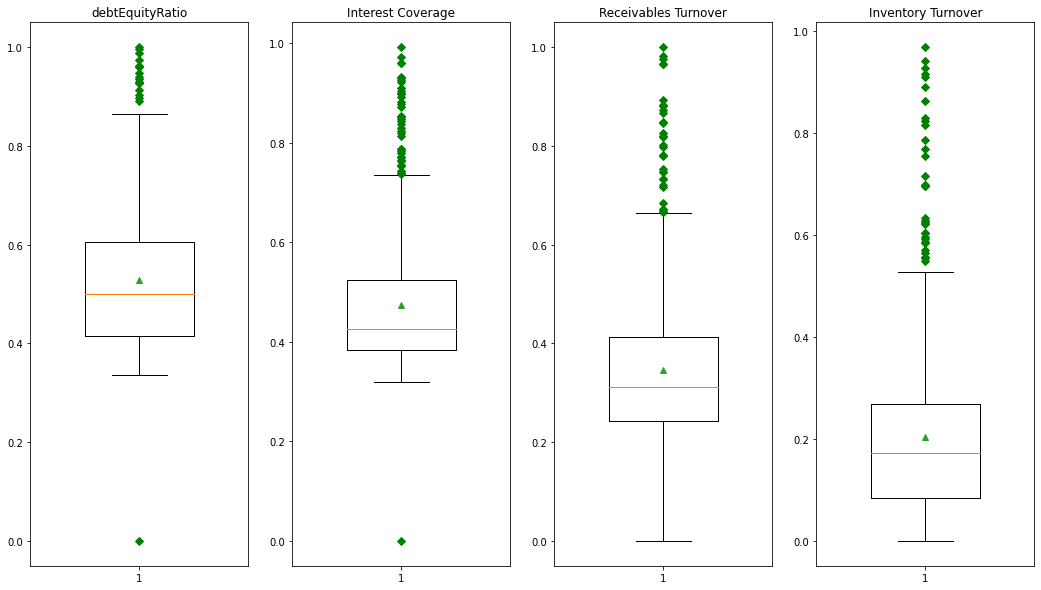

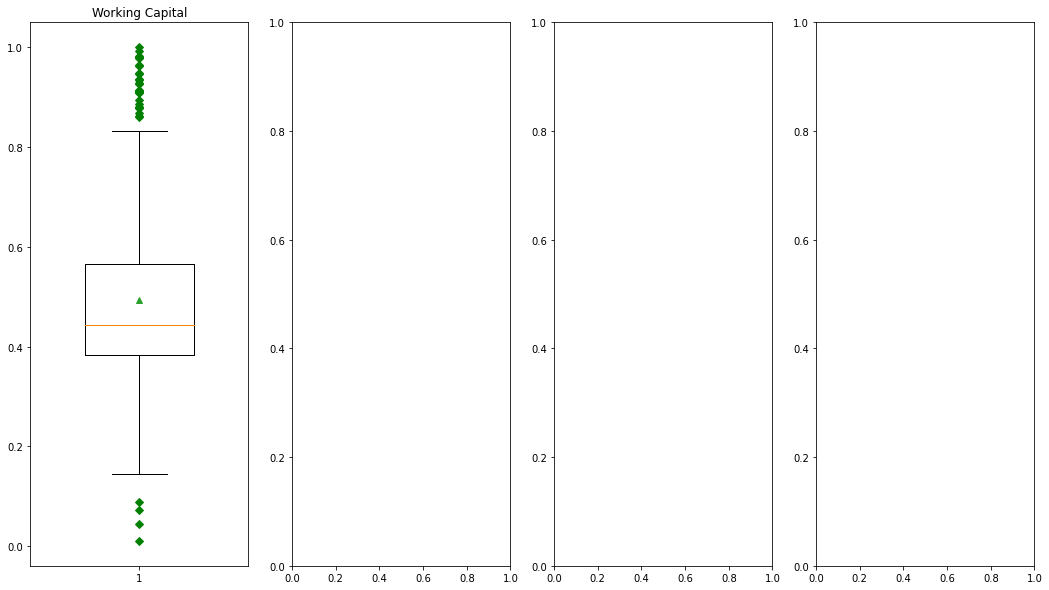

In [387]:
get_box(indicator_data.loc[indicator_data['Data Year']==2018], indicator_data.columns.values.tolist()[3:])

In [388]:
# indicator_data['EPS'].plot(kind='kde', figsize=(15,10))
# indicator_data['EPS'].plot(kind='bar', figsize=(10,5))
# indicator_data.plot(kind='scatter', x='priceEarningsRatio', y='Class', figsize=(10,5))
# indicator_data.loc[indicator_data['Class']==0].plot(kind='scatter', x='priceEarningsRatio', y='Class', figsize=(15,10))
# indicator_data.loc[indicator_data['Class']==0].describe()

<AxesSubplot:>

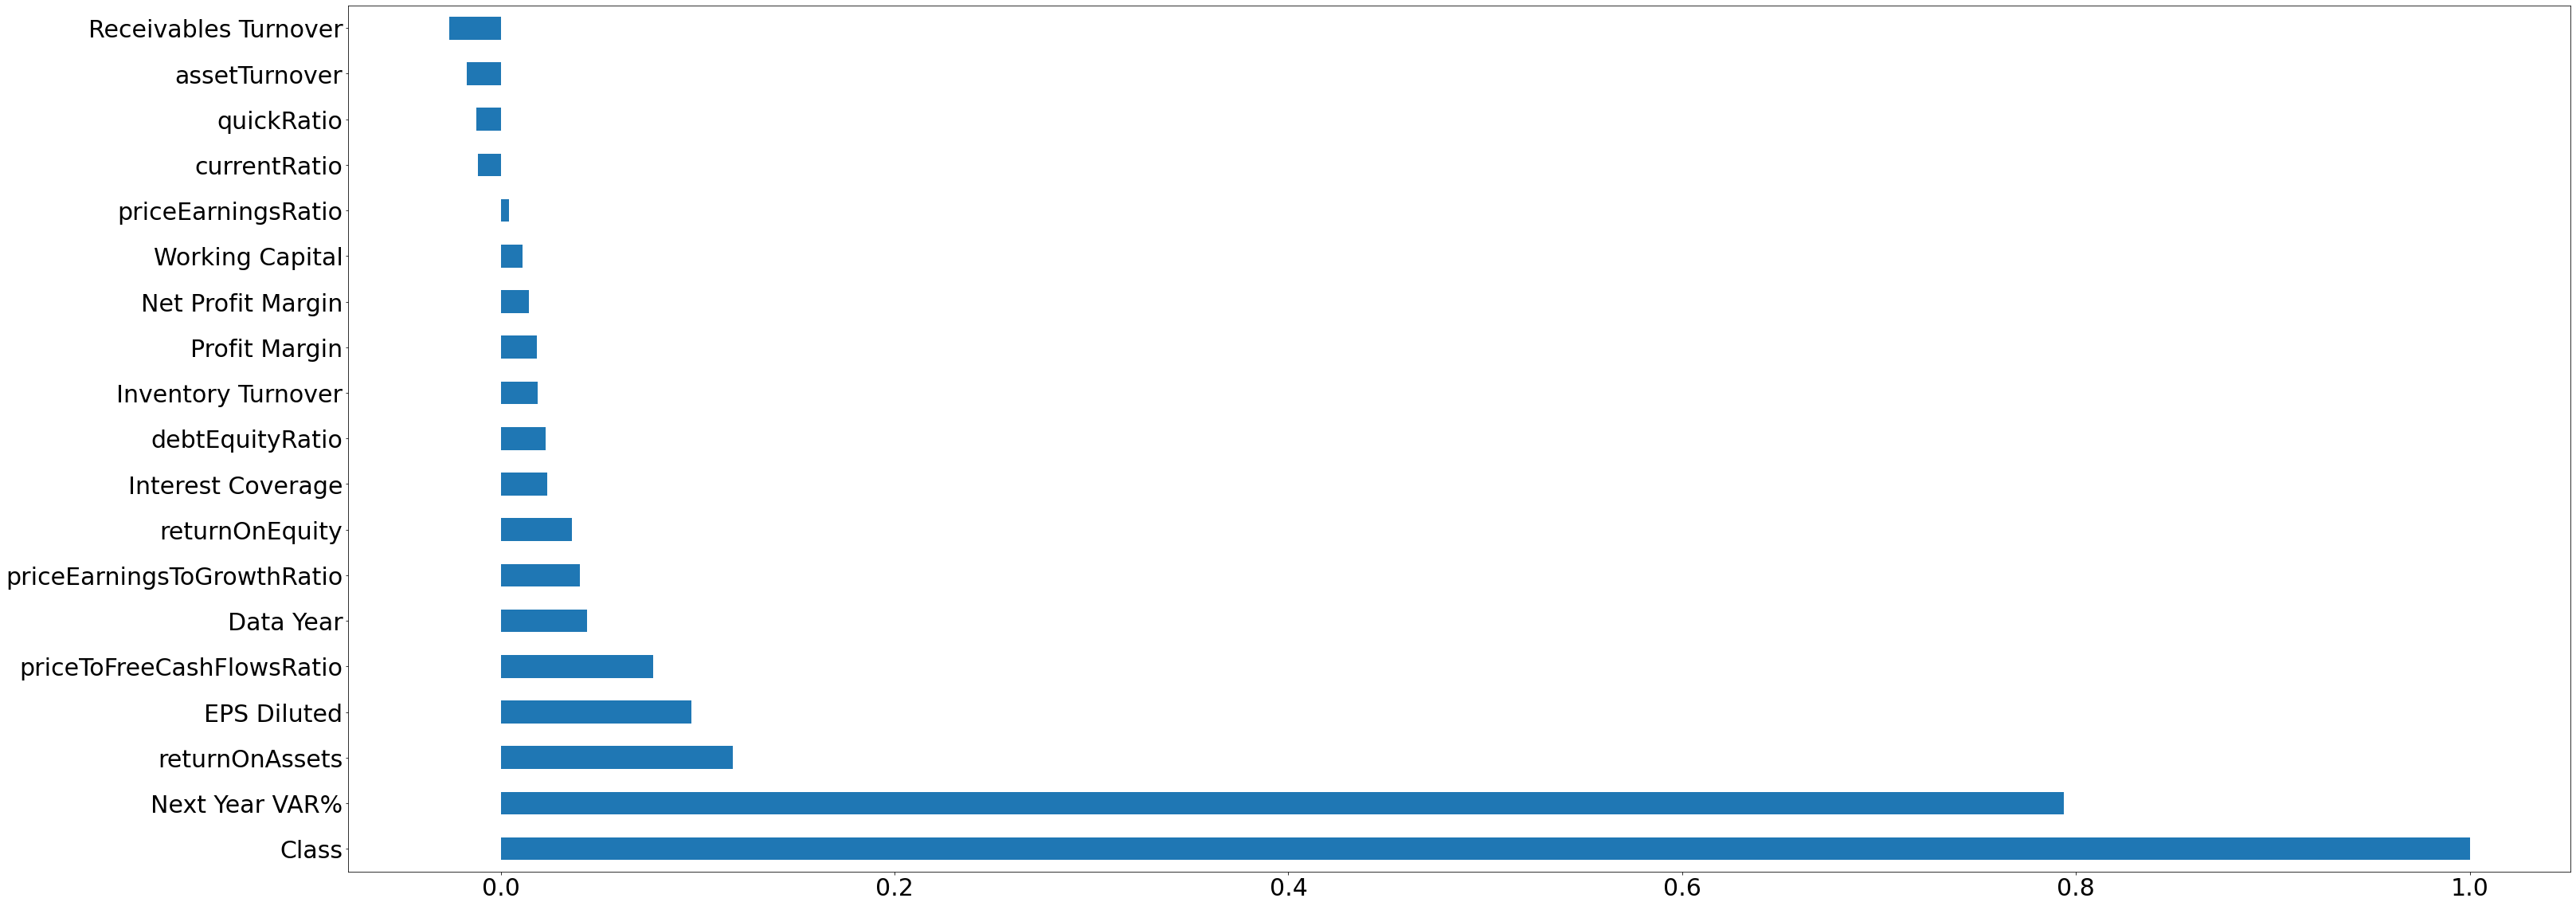

In [530]:
s = indicator_data.corr()['Class'].sort_values(ascending=False)
s.describe()
s.plot(kind='barh', figsize=(50,20), fontsize=30)

## Modeling
Here we start to create and evaluate various classification models

### Create train test split

In [444]:
# 1. Define X, y
# y = Class (recommend or not recommend)
# X = columns
y = indicator_data['Class'].values
X = indicator_data[feature_column].values
# 2. Check if we need shuffle the independent variables
 
indicator_data['Class'].value_counts()
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

train_idx, test_idx = next(splitter.split(X,y))
# Create the data sets
X_train = indicator_data.loc[train_idx, feature_column]
y_train = indicator_data.loc[train_idx, 'Class']

X_test = indicator_data.loc[test_idx, feature_column]
y_test = indicator_data.loc[test_idx, 'Class']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1665, 17)
(1665,)
(714, 17)
(714,)


In [391]:
# train_sample_idx = np.random.choice(train_idx, int(len(train_idx)*0.3))
# test_sample_idx = np.random.choice(test_idx, int(len(test_idx)*0.3))
# # Create the data sets
# X_train = indicator_data.loc[train_sample_idx, columns]
# y_train = indicator_data.loc[train_sample_idx, 'Class']

# X_test = indicator_data.loc[test_sample_idx, columns]
# y_test = indicator_data.loc[test_sample_idx, 'Class']

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

### Logistic Regression
Here we start with Logistic Regression

In [445]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', n_jobs=-1, max_iter=1000).fit(X_train, y_train)
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear', n_jobs=-1, max_iter=1000).fit(X_train, y_train)

In [393]:
# import pickle
# with open(path + 'L1_LogisticRegressionCV_2.pickle', 'wb') as f:
#     pickle.dump(lr_l1, f)
    
# with open(path + 'L2_LogisticRegressionCV_2.pickle', 'wb') as f:
#     pickle.dump(lr_l2, f)

In [394]:
# f1 = open(path + 'L1_LogisticRegressionCV_2.pickle', 'rb')
# lr_l1 = pickle.load(f1)
    
# f2 = open(path + 'L2_LogisticRegressionCV_2.pickle', 'rb')
# lr_l2 = pickle.load(f2)

In [519]:
def plotCM(title, y_test, y_predict):
    fig, axList = plt.subplots()
    fig.set_size_inches(10, 5)
    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
    ax.set(title=title)
    plt.tight_layout()

In [515]:
# Run simple Linear Regression, and with L1, L2 penalty
lr_list = [lr, lr_l1, lr_l2]
lr_type = ['LR', 'L1', 'L2']
lr_cm = {}
lr_cm_list = []
auc_list = []
for model, model_type in zip(lr_list, lr_type):
    y_hat = model.predict(X_test)
    y_hat_proba = model.predict_proba(X_test)
    cm = confusion_matrix(y_test, y_hat)
    lr_cm[model_type] = cm
    result = classification_report(y_test, y_hat
                                   , output_dict=True
                                  ) 
    lr_cm_list.append(result)
    arr = model.predict_proba(X_test)
    auc_score = round(roc_auc_score(y_test, arr[:,1]),4)
    auc_list.append(auc_score)

In [516]:
report_columns = ['precision', 'recall', 'f1-score', 'support']
index = ['0', '1']
for cm, model_type, auc in zip(lr_cm_list, lr_type, auc_list):
    df_0 = pd.DataFrame(data=cm['0'], index=['0']) 
    df_1 = pd.DataFrame(data=cm['1'], index=['1'])
    df = pd.concat([df_0, df_1], axis=0)
    print('The classification report for {}: '.format(model_type))
    print(df)
    print('The accuracy for {} is {}'.format(model_type, cm['accuracy']))
    print('The roc_auc_score for {} is {}'.format(model_type, auc))
    print('\n')

The classification report for LR: 
   precision    recall  f1-score  support
0   0.972509  0.933993  0.952862      303
1   0.952719  0.980535  0.966427      411
The accuracy for LR is 0.9607843137254902
The roc_auc_score for LR is 0.9961


The classification report for L1: 
   precision    recall  f1-score  support
0   0.996678  0.990099  0.993377      303
1   0.992736  0.997567  0.995146      411
The accuracy for L1 is 0.9943977591036415
The roc_auc_score for L1 is 0.9998


The classification report for L2: 
   precision    recall  f1-score  support
0   0.996678  0.990099  0.993377      303
1   0.992736  0.997567  0.995146      411
The accuracy for L2 is 0.9943977591036415
The roc_auc_score for L2 is 0.9998




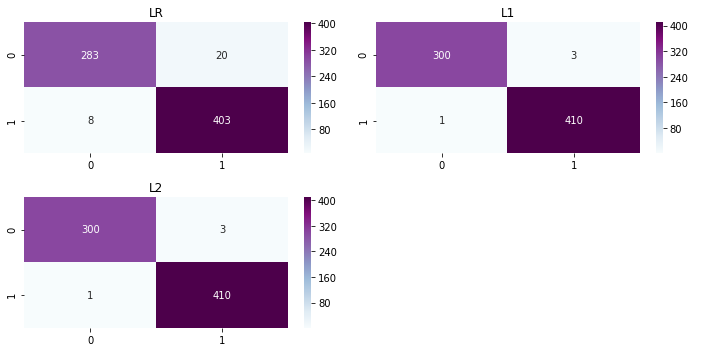

In [517]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 5)
axList[-1].axis('off')
for ax, model_type in zip(axList[:-1], lr_type):
    sns.heatmap(lr_cm[model_type], ax=ax, annot=True, fmt='d',cmap='BuPu');
    ax.set(title=model_type);
plt.tight_layout()

### K-Nearest Neighbors
Here we test KNN classifier

KNeighborsClassifier(n_jobs=-1, n_neighbors=8, p=1)
{'n_jobs': -1, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       303
           1       0.85      0.89      0.87       411

    accuracy                           0.85       714
   macro avg       0.85      0.84      0.84       714
weighted avg       0.85      0.85      0.85       714

Accuracy score:  0.8473
F1 Score:  0.8707


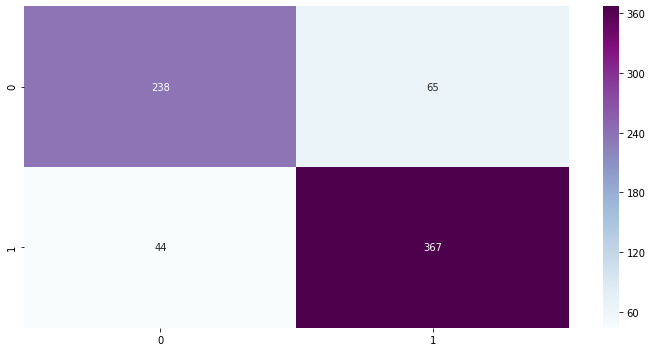

In [520]:
# Test KNN with GridSearchCV
param_dict = {'n_neighbors':range(1,10),
              'weights':['uniform', 'distance'],
              'n_jobs':[-1],
              'p':[1,2]
             }
gcv = GridSearchCV(KNeighborsClassifier(), param_dict)
gcv.fit(X_train, y_train)
y_hat_gcv = gcv.predict(X_test)
# print(gcv.get_params())
print(gcv.best_estimator_)
print(gcv.best_params_)
print(classification_report(y_test, y_hat_gcv))
print('Accuracy score: ', round(accuracy_score(y_test, y_hat_gcv), 4))
print('F1 Score: ', round(f1_score(y_test, y_hat_gcv), 4))

plotCM('KNN', y_test, y_hat_gcv)

In [469]:
arr = gcv.predict_proba(X_test)
round(roc_auc_score(y_test, arr[:,1]),4)

0.918

### Support Vector Machine
Here we evaluate SVM

SVC(degree=1, gamma=10, kernel='poly', probability=True)
{'degree': 1, 'gamma': 10, 'kernel': 'poly', 'probability': True}
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       303
           1       0.98      0.99      0.99       411

    accuracy                           0.98       714
   macro avg       0.98      0.98      0.98       714
weighted avg       0.98      0.98      0.98       714

Accuracy score:  0.9832
F1 Score:  0.9855


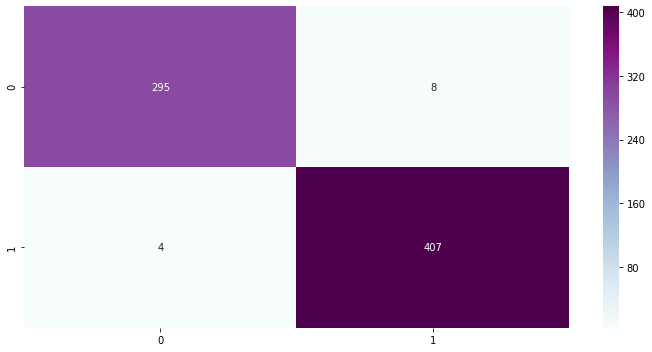

In [522]:
param_dict = {'kernel':['poly', 'rbf', 'sigmoid'],
              'degree':range(1,5),
              'gamma':[.5, 1, 2, 10],
              'probability':[True]
             }
gcv_svc = GridSearchCV(SVC(), param_dict)
gcv_svc.fit(X_train, y_train)
y_hat_gcv_svc = gcv_svc.predict(X_test)
print(gcv_svc.best_estimator_)
print(gcv_svc.best_params_)
# print(gcv_svc.get_params())
print(classification_report(y_test, y_hat_gcv_svc))
print('Accuracy score: ', round(accuracy_score(y_test, y_hat_gcv_svc), 4))
print('F1 Score: ', round(f1_score(y_test, y_hat_gcv_svc), 4))

plotCM('GCV SVC', y_test, y_hat_gcv_svc)

In [523]:
arr = gcv_svc.predict_proba(X_test)
round(roc_auc_score(y_test, arr[:,1]),4)

0.9991

### Decision Tree

DecisionTreeClassifier(max_depth=1, max_features=10, random_state=42)
{'max_depth': 1, 'max_features': 10}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       303
           1       1.00      1.00      1.00       411

    accuracy                           1.00       714
   macro avg       1.00      1.00      1.00       714
weighted avg       1.00      1.00      1.00       714

Accuracy score:  0.9972
F1 Score:  0.9976


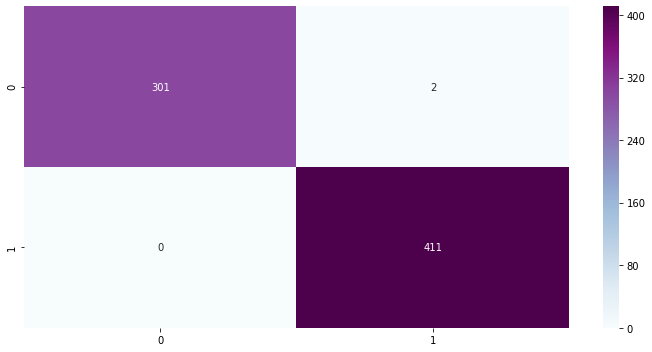

In [524]:
# Decision Tree
# Try to get the tree structure
tree = DecisionTreeClassifier(random_state=42)
tree = tree.fit(X_train, y_train)
tree_depth = tree.tree_.max_depth
tree_features_length = len(tree.feature_importances_)
# Use grid search for the best hyperparameter
param_grid = {'max_depth':range(1, tree_depth+1, 2),
              'max_features': range(1, tree_features_length+1)}
gcv_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  n_jobs=-1)
gcv_dt.fit(X_train, y_train)
y_hat_gcv_dt = gcv_dt.predict(X_test)
print(gcv_dt.best_estimator_)
print(gcv_dt.best_params_)
print(classification_report(y_test, y_hat_gcv_dt))
print('Accuracy score: ', round(accuracy_score(y_test, y_hat_gcv_dt), 4))
print('F1 Score: ', round(f1_score(y_test, y_hat_gcv_dt), 4))

plotCM('GCV DT', y_test, y_hat_gcv_dt)

In [473]:
arr = gcv_dt.predict_proba(X_test)
round(roc_auc_score(y_test, arr[:,1]),4)

0.9967

### Random Forest

RandomForestClassifier(max_features='sqrt', n_estimators=15, random_state=42,
                       warm_start=True)
{'max_features': 'sqrt', 'n_estimators': 15, 'warm_start': True}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00       411

    accuracy                           1.00       714
   macro avg       1.00      1.00      1.00       714
weighted avg       1.00      1.00      1.00       714

Accuracy score:  0.9972
F1 Score:  0.9976


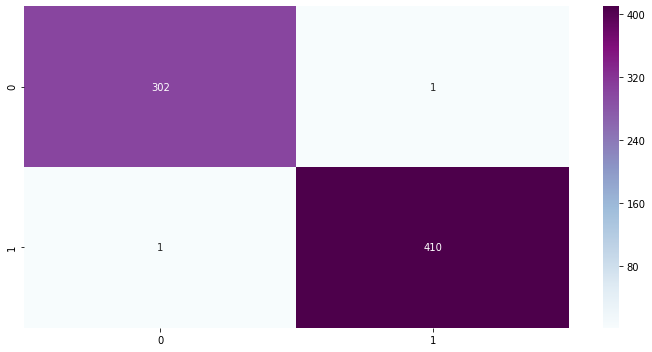

In [525]:
# rfc = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators':[15, 20, 30, 40, 50, 100, 150, 200, 300, 400],
#               'oob_score': [True],
              'max_features': ['sqrt', 'log2'],
              'warm_start':[True]
             }
gcv_rfc = GridSearchCV(RandomForestClassifier(random_state=42),
                  param_grid=param_grid,
                  n_jobs=-1)
gcv_rfc.fit(X_train, y_train)
y_hat_gcv_rfc = gcv_rfc.predict(X_test)

print(gcv_rfc.best_estimator_)
print(gcv_rfc.best_params_)

# print(gcv_rfc.get_params())
print(classification_report(y_test, y_hat_gcv_rfc))
print('Accuracy score: ', round(accuracy_score(y_test, y_hat_gcv_rfc), 4))
print('F1 Score: ', round(f1_score(y_test, y_hat_gcv_rfc), 4))

plotCM('GCV Random Forest', y_test, y_hat_gcv_rfc)

In [526]:
arr = gcv_rfc.predict_proba(X_test)
round(roc_auc_score(y_test, arr[:,1]),4)

1.0

### Boosting

GradientBoostingClassifier(max_features=1, random_state=42)
{'learning_rate': 0.1, 'max_features': 1, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       303
           1       1.00      1.00      1.00       411

    accuracy                           1.00       714
   macro avg       1.00      1.00      1.00       714
weighted avg       1.00      1.00      1.00       714

Accuracy score:  0.9972
F1 Score:  0.9976


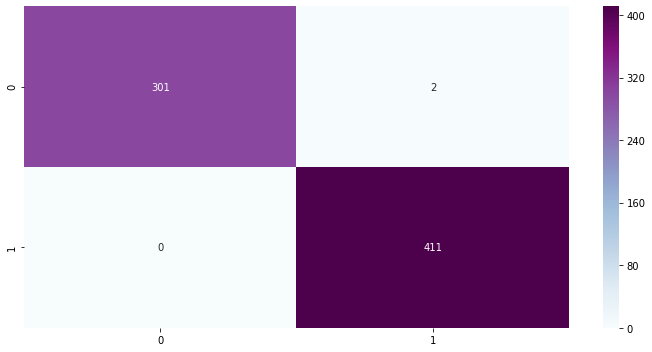

In [527]:
# The parameters to be fit
tree_list = [15, 25, 50, 100, 200, 400]
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
gcv_boosting = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

gcv_boosting.fit(X_train, y_train)
y_hat_gcv_boosting = gcv_boosting.predict(X_test)

print(gcv_boosting.best_estimator_)
print(gcv_boosting.best_params_)

print(classification_report(y_test, y_hat_gcv_boosting))
print('Accuracy score: ', round(accuracy_score(y_test, y_hat_gcv_boosting), 4))
print('F1 Score: ', round(f1_score(y_test, y_hat_gcv_boosting), 4))

plotCM('GCV Boosting', y_test, y_hat_gcv_boosting)

In [475]:
arr = gcv_boosting.predict_proba(X_test)
round(roc_auc_score(y_test, arr[:,1]),4)

0.9978